# Testing for Order Permutation Invariance

In [75]:
import torch
import torch.optim as optim
import torchvision
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set("paper", rc={"font.size":20,
                     "axes.titlesize":25,
                     "axes.labelsize":20,
                     "lines.linewidth":2,
                     "lines.markersize":5,
                     "xtick.labelsize":14,
                     "ytick.labelsize":14}) 

sns.set_palette(sns.cubehelix_palette(10, start=.5, rot=-.75))

from models import *
from utils import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# check if CUDA is available
device = torch.device("cpu")
use_cuda = False
if torch.cuda.is_available():
    print('CUDA is available!')
    device = torch.device("cuda")
    use_cuda = True
else:
    print('CUDA is not available.')

CUDA is available!


### Load Models

In [3]:
## FCNet5
fcnet5 = FCNet5().to(device)
fcnet5, _  = get_pretrained_weights(fcnet5) 

## FCNet10
fcnet10 = FCNet10().to(device) 
fcnet10, _  = get_pretrained_weights(fcnet10)

## Conv1DNet
conv1dnet = Conv1DNet().to(device)
conv1dnet, _  = get_pretrained_weights(conv1dnet)

## Conv2DNet
conv2dnet = Conv2DNet().to(device)
conv2dnet, _  = get_pretrained_weights(conv2dnet)

loading model pretrained_models/mnist\model_FCNet5_2019-10-01 19.54.00.177928_97.96.pth
loading model pretrained_models/mnist\model_FCNet10_2019-10-01 20.00.52.119894_97.92.pth
loading model pretrained_models/mnist\model_Conv1DNet_2019-10-02 00.20.02.430722_98.17.pth
loading model pretrained_models/mnist\model_Conv2DNet_2019-07-25 16.16.26.580052_98.82.pth


## Separating inputs by class
Allows us to recreate new distributions to train / test upon. 

In [4]:
shape=(-1,1,28,28)

In [5]:
def stratify_dataset(dataset, shape=(-1,1,28,28), reverse=False, return_set=True):
    X, y = [], []
    for target in dataset.targets.unique():
        idx = dataset.targets == target
        target_data = dataset.data[idx].float().view(shape)
        target_labels = dataset.targets[idx]
        X.append(target_data)
        y.append(target_labels)
    X, y = torch.cat(X) / 255, torch.cat(y)
    if reverse:
        X, y = reverse_order(X), reverse_order(y)
    if return_set:
        return torch.utils.data.TensorDataset(X, y)
    return X, y

def reverse_order(tensor):
    return tensor.flip((0))

def display_img(tensor):
    img = tensor.cpu().numpy().astype(np.uint8).squeeze()
    print(img.shape)
    plt.imshow(img)
    plt.show()

In [6]:
data_dir = "C:\data\MNIST"

#original datasets
data_train = torchvision.datasets.MNIST(data_dir, 
                                        train=True, 
                                        download=True,
                                        transform=torchvision.transforms.Compose([
                                           torchvision.transforms.ToTensor()
                                        ]))

data_test = torchvision.datasets.MNIST(data_dir, 
                                       train=False, 
                                       download=True,
                                       transform=torchvision.transforms.Compose([
                                         torchvision.transforms.ToTensor()
                                       ]))

# stratified datasets
data_train_s = stratify_dataset(data_train, reverse=False, return_set=True)
data_test_s = stratify_dataset(data_test, reverse=False, return_set=True)

# reverse stratified datasets
data_train_sr = stratify_dataset(data_train, reverse=True, return_set=True)
data_test_sr = stratify_dataset(data_test, reverse=True, return_set=True)

In [7]:
# original data
X_train, y_train = data_train.data.float().view(shape) / 255, data_train.targets
X_test, y_test = data_test.data.float().view(shape) / 255, data_test.targets

In [8]:
# stratified dataset
X_train_s, y_train_s = stratify_dataset(data_train, reverse=False, return_set=False)
X_test_s, y_test_s = stratify_dataset(data_test, reverse=False, return_set=False)

In [9]:
# reverse stratified dataset
X_train_sr, y_train_sr = stratify_dataset(data_train, reverse=True, return_set=False)
X_test_sr, y_test_sr = stratify_dataset(data_test, reverse=True, return_set=False)

## Accuracy Per Class

In [331]:
for X, y, desc in [(X_test, y_test, 'original')]:
    print(desc)
    for model in [fcnet5, fcnet10, conv1dnet, conv2dnet]:
        model.cpu()
        model.eval()
        model_type = model.__class__.__name__
        for i in y_test_s.unique():
            idx = y == i
            X_ = X[idx]
            y_ = y[idx]
            acc = get_accuracy(model, X_, y_)
            print('model_type:', model_type, '\t', 
                  'label:', i.item(), '\t', 
                  'count:', len(y_), '\t',
                  'acc:', acc.item())
        acc = get_accuracy(model, X, y)
        print('model_type:', model_type, '\t', 
              'label:', 'all', '\t', 
              'count:', len(y), '\t',
              'acc:', acc.item(), '\n')

original
model_type: FCNet5 	 label: 0 	 count: 980 	 acc: 0.9928571581840515
model_type: FCNet5 	 label: 1 	 count: 1135 	 acc: 0.9894273281097412
model_type: FCNet5 	 label: 2 	 count: 1032 	 acc: 0.9757751822471619
model_type: FCNet5 	 label: 3 	 count: 1010 	 acc: 0.9881188273429871
model_type: FCNet5 	 label: 4 	 count: 982 	 acc: 0.9867616891860962
model_type: FCNet5 	 label: 5 	 count: 892 	 acc: 0.9865471124649048
model_type: FCNet5 	 label: 6 	 count: 958 	 acc: 0.9843423962593079
model_type: FCNet5 	 label: 7 	 count: 1028 	 acc: 0.9717898964881897
model_type: FCNet5 	 label: 8 	 count: 974 	 acc: 0.9517453908920288
model_type: FCNet5 	 label: 9 	 count: 1009 	 acc: 0.9682854413986206
model_type: FCNet5 	 label: all 	 count: 10000 	 acc: 0.9796000123023987 

model_type: FCNet10 	 label: 0 	 count: 980 	 acc: 0.9908163547515869
model_type: FCNet10 	 label: 1 	 count: 1135 	 acc: 0.9876651763916016
model_type: FCNet10 	 label: 2 	 count: 1032 	 acc: 0.9883720874786377
model_typ

## Evaluate Permutation on Inference

### Prediction per Model

In [332]:
for X, y, desc in [(X_test, y_test, 'original'), 
                   (X_test_s, y_test_s, 'stratified'), 
                   (X_test_sr, y_test_sr, 'reverse stratified')]:
    print(desc)
    for model in [fcnet5, fcnet10, conv1dnet, conv2dnet]:
        model.cpu()
        model.eval()
        model_type = model.__class__.__name__
        acc = get_accuracy(model, X, y)
        print('model_type:', model_type, '\t', 'acc:', acc.item())
    print('')

original
model_type: FCNet5 	 acc: 0.9796000123023987
model_type: FCNet10 	 acc: 0.979200005531311
model_type: Conv1DNet 	 acc: 0.9817000031471252
model_type: Conv2DNet 	 acc: 0.9882000088691711

stratified
model_type: FCNet5 	 acc: 0.9796000123023987
model_type: FCNet10 	 acc: 0.979200005531311
model_type: Conv1DNet 	 acc: 0.9817000031471252
model_type: Conv2DNet 	 acc: 0.9882000088691711

reverse stratified
model_type: FCNet5 	 acc: 0.9796000123023987
model_type: FCNet10 	 acc: 0.979200005531311
model_type: Conv1DNet 	 acc: 0.9817000031471252
model_type: Conv2DNet 	 acc: 0.9882000088691711



The ordering of the inputs does not affect prediction. 

## Evaluate Permutation on Training

In [11]:
random_seed = 1
torch.manual_seed(random_seed)

In [12]:
batch_size_train = 10
batch_size_test = 100

### Stratified

In [77]:
train_s_loader = torch.utils.data.DataLoader(data_train_s,
    batch_size=batch_size_train, shuffle=False, pin_memory=True)

test_s_loader = torch.utils.data.DataLoader(data_test_s,
    batch_size=batch_size_test, shuffle=False, pin_memory=True)

In [14]:
n_epochs = 100

save_dir = 'pretrained_models/mnist/permutation/stratified/'

for model in [FCNet5, FCNet10, Conv1DNet, Conv2DNet]:
    
    model = model().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

    m_type = model.__class__.__name__
    
    print('training for model', m_type)
    
    for epoch in range(1, n_epochs + 1):
        train(model, device, train_s_loader, optimizer, epoch)
        acc = test(model, device, test_s_loader)  

    torch.save(model.state_dict(), save_dir + 'model_' + m_type + '_' + str(datetime.date.today()) + '_' + str(acc) + '.pth')

training for model FCNet5
Train Epoch: 1 [0/60000 (0%)] 	 Loss: 2.395158
Train Epoch: 1 [100/60000 (0%)] 	 Loss: 2.188215
Train Epoch: 1 [200/60000 (0%)] 	 Loss: 1.955820
Train Epoch: 1 [300/60000 (0%)] 	 Loss: 1.709948
Train Epoch: 1 [400/60000 (1%)] 	 Loss: 1.448674
Train Epoch: 1 [500/60000 (1%)] 	 Loss: 1.132358
Train Epoch: 1 [600/60000 (1%)] 	 Loss: 0.723799
Train Epoch: 1 [700/60000 (1%)] 	 Loss: 0.390742
Train Epoch: 1 [800/60000 (1%)] 	 Loss: 0.208495
Train Epoch: 1 [900/60000 (2%)] 	 Loss: 0.095392
Train Epoch: 1 [1000/60000 (2%)] 	 Loss: 0.050205
Train Epoch: 1 [1100/60000 (2%)] 	 Loss: 0.017825
Train Epoch: 1 [1200/60000 (2%)] 	 Loss: 0.049943
Train Epoch: 1 [1300/60000 (2%)] 	 Loss: 0.005850
Train Epoch: 1 [1400/60000 (2%)] 	 Loss: 0.012031
Train Epoch: 1 [1500/60000 (2%)] 	 Loss: 0.058844
Train Epoch: 1 [1600/60000 (3%)] 	 Loss: 0.029538
Train Epoch: 1 [1700/60000 (3%)] 	 Loss: 0.002957
Train Epoch: 1 [1800/60000 (3%)] 	 Loss: 0.002312
Train Epoch: 1 [1900/60000 (3%)] 	 L

KeyboardInterrupt: 

In [78]:
weight_dir = "pretrained_models/mnist/permutation/stratified/"

## DenseNet5
fcnet5 = FCNet5().to(device)
fcnet5, _  = get_pretrained_weights(fcnet5, weight_dir) 

## DenseNet10
fcnet10 = FCNet10().to(device) 
fcnet10, _  = get_pretrained_weights(fcnet10, weight_dir) 

## Conv1DNet
conv1dnet = Conv1DNet().to(device)
conv1dnet, _  = get_pretrained_weights(conv1dnet, weight_dir) 

## Conv2DNet
conv2dnet = Conv2DNet().to(device)
conv2dnet, _  = get_pretrained_weights(conv2dnet, weight_dir) 

loading model pretrained_models/mnist/permutation/stratified\model_FCNet5_2020-05-17_e100_61.24.pth
loading model pretrained_models/mnist/permutation/stratified\model_FCNet10_2020-05-17_e100_10.09.pth
loading model pretrained_models/mnist/permutation/stratified\model_Conv1DNet_2020-05-17_e100_10.09.pth
loading model pretrained_models/mnist/permutation/stratified\model_Conv2DNet_2020-05-17_e100_10.09.pth


stratified
model_type: FCNet5 	 label: 0 	 count: 980 	 acc: 0.7510204315185547
model_type: FCNet5 	 label: 1 	 count: 1135 	 acc: 0.9118942618370056
model_type: FCNet5 	 label: 2 	 count: 1032 	 acc: 0.3759689927101135
model_type: FCNet5 	 label: 3 	 count: 1010 	 acc: 0.7475247383117676
model_type: FCNet5 	 label: 4 	 count: 982 	 acc: 0.1384928673505783
model_type: FCNet5 	 label: 5 	 count: 892 	 acc: 0.6412556171417236
model_type: FCNet5 	 label: 6 	 count: 958 	 acc: 0.8841336369514465
model_type: FCNet5 	 label: 7 	 count: 1028 	 acc: 0.2558365762233734
model_type: FCNet5 	 label: 8 	 count: 974 	 acc: 0.395277202129364
model_type: FCNet5 	 label: 9 	 count: 1009 	 acc: 0.9980178475379944


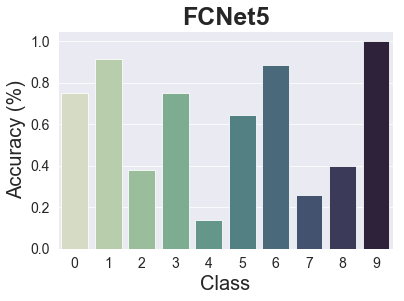

model_type: FCNet5 	 label: all 	 count: 10000 	 acc: 0.6123999953269958 

model_type: FCNet10 	 label: 0 	 count: 980 	 acc: 0.0
model_type: FCNet10 	 label: 1 	 count: 1135 	 acc: 0.0
model_type: FCNet10 	 label: 2 	 count: 1032 	 acc: 0.0
model_type: FCNet10 	 label: 3 	 count: 1010 	 acc: 0.0
model_type: FCNet10 	 label: 4 	 count: 982 	 acc: 0.0
model_type: FCNet10 	 label: 5 	 count: 892 	 acc: 0.0
model_type: FCNet10 	 label: 6 	 count: 958 	 acc: 0.0
model_type: FCNet10 	 label: 7 	 count: 1028 	 acc: 0.0
model_type: FCNet10 	 label: 8 	 count: 974 	 acc: 0.0
model_type: FCNet10 	 label: 9 	 count: 1009 	 acc: 1.0


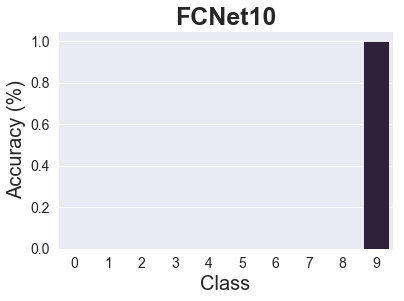

model_type: FCNet10 	 label: all 	 count: 10000 	 acc: 0.10090000182390213 

model_type: Conv1DNet 	 label: 0 	 count: 980 	 acc: 0.0
model_type: Conv1DNet 	 label: 1 	 count: 1135 	 acc: 0.0
model_type: Conv1DNet 	 label: 2 	 count: 1032 	 acc: 0.0
model_type: Conv1DNet 	 label: 3 	 count: 1010 	 acc: 0.0
model_type: Conv1DNet 	 label: 4 	 count: 982 	 acc: 0.0
model_type: Conv1DNet 	 label: 5 	 count: 892 	 acc: 0.0
model_type: Conv1DNet 	 label: 6 	 count: 958 	 acc: 0.0
model_type: Conv1DNet 	 label: 7 	 count: 1028 	 acc: 0.0
model_type: Conv1DNet 	 label: 8 	 count: 974 	 acc: 0.0
model_type: Conv1DNet 	 label: 9 	 count: 1009 	 acc: 1.0


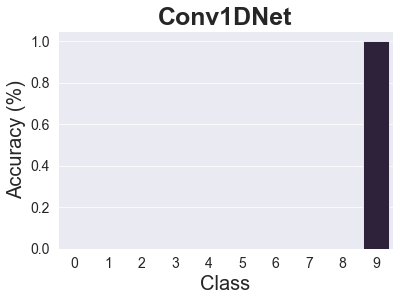

model_type: Conv1DNet 	 label: all 	 count: 10000 	 acc: 0.10090000182390213 

model_type: Conv2DNet 	 label: 0 	 count: 980 	 acc: 0.0
model_type: Conv2DNet 	 label: 1 	 count: 1135 	 acc: 0.0
model_type: Conv2DNet 	 label: 2 	 count: 1032 	 acc: 0.0
model_type: Conv2DNet 	 label: 3 	 count: 1010 	 acc: 0.0
model_type: Conv2DNet 	 label: 4 	 count: 982 	 acc: 0.0
model_type: Conv2DNet 	 label: 5 	 count: 892 	 acc: 0.0
model_type: Conv2DNet 	 label: 6 	 count: 958 	 acc: 0.0
model_type: Conv2DNet 	 label: 7 	 count: 1028 	 acc: 0.0
model_type: Conv2DNet 	 label: 8 	 count: 974 	 acc: 0.0
model_type: Conv2DNet 	 label: 9 	 count: 1009 	 acc: 1.0


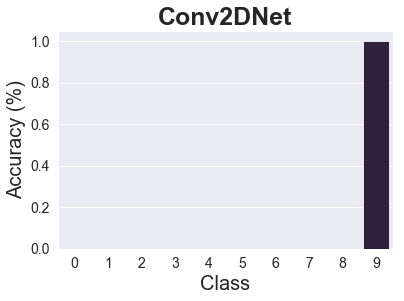

model_type: Conv2DNet 	 label: all 	 count: 10000 	 acc: 0.10090000182390213 



In [80]:
per_class_acc = np.zeros((10))
for X, y, desc in [(X_test_s, y_test_s, 'stratified')]:
    print(desc)
    for model in [fcnet5, fcnet10, conv1dnet, conv2dnet]:
        model.cpu()
        model.eval()
        model_type = model.__class__.__name__
        for i in y_test_s.unique():
            idx = y == i
            X_ = X[idx]
            y_ = y[idx]
            acc = get_accuracy(model, X_, y_)
            per_class_acc[i] = acc
            print('model_type:', model_type, '\t', 
                  'label:', i.item(), '\t', 
                  'count:', len(y_), '\t',
                  'acc:', acc.item())
        sns.barplot(x=np.arange(len(per_class_acc)),y=per_class_acc)
        plt.xlabel('Class')
        plt.ylabel('Accuracy (%)')
        plt.title(label=model_type, weight='bold')
        plt.savefig('imgs/order_permutation/order_permutation_s_e100_'+model_type+'.png')
        plt.show()
        acc = get_accuracy(model, X, y)
        print('model_type:', model_type, '\t', 
              'label:', 'all', '\t', 
              'count:', len(y), '\t',
              'acc:', acc.item(), '\n')

### Reverse Stratified

In [81]:
train_sr_loader = torch.utils.data.DataLoader(data_train_sr,
    batch_size=batch_size_train, shuffle=False, pin_memory=True)

test_sr_loader = torch.utils.data.DataLoader(data_test_sr,
    batch_size=batch_size_test, shuffle=False, pin_memory=True)

In [17]:
n_epochs = 100

save_dir = 'pretrained_models/mnist/permutation/reverse_stratified/'

for model in [FCNet5, FCNet10, Conv1DNet, Conv2DNet]:
    
    model = model().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

    m_type = model.__class__.__name__
    
    print('training for model', m_type)
    
    for epoch in range(1, n_epochs + 1):
        train(model, device, train_sr_loader, optimizer, epoch)
        acc = test(model, device, test_sr_loader)  

    torch.save(model.state_dict(), save_dir + 'model_' + m_type + '_' + str(datetime.date.today()) + '_' + str(acc) + '.pth')

training for model FCNet5
Train Epoch: 1 [0/60000 (0%)] 	 Loss: 2.280841
Train Epoch: 1 [100/60000 (0%)] 	 Loss: 2.065190
Train Epoch: 1 [200/60000 (0%)] 	 Loss: 1.844400
Train Epoch: 1 [300/60000 (0%)] 	 Loss: 1.611535
Train Epoch: 1 [400/60000 (1%)] 	 Loss: 1.390978
Train Epoch: 1 [500/60000 (1%)] 	 Loss: 1.143779
Train Epoch: 1 [600/60000 (1%)] 	 Loss: 0.882491
Train Epoch: 1 [700/60000 (1%)] 	 Loss: 0.494513
Train Epoch: 1 [800/60000 (1%)] 	 Loss: 0.189775
Train Epoch: 1 [900/60000 (2%)] 	 Loss: 0.129976
Train Epoch: 1 [1000/60000 (2%)] 	 Loss: 0.102643
Train Epoch: 1 [1100/60000 (2%)] 	 Loss: 0.051542
Train Epoch: 1 [1200/60000 (2%)] 	 Loss: 0.031915
Train Epoch: 1 [1300/60000 (2%)] 	 Loss: 0.007140
Train Epoch: 1 [1400/60000 (2%)] 	 Loss: 0.039681
Train Epoch: 1 [1500/60000 (2%)] 	 Loss: 0.016650
Train Epoch: 1 [1600/60000 (3%)] 	 Loss: 0.006380
Train Epoch: 1 [1700/60000 (3%)] 	 Loss: 0.018530
Train Epoch: 1 [1800/60000 (3%)] 	 Loss: 0.015690
Train Epoch: 1 [1900/60000 (3%)] 	 L

KeyboardInterrupt: 

In [82]:
weight_dir = "pretrained_models/mnist/permutation/reverse_stratified/"

## DenseNet5
fcnet5 = FCNet5().to(device)
fcnet5, _ = get_pretrained_weights(fcnet5, weight_dir) 

## DenseNet10
fcnet10 = FCNet10().to(device) 
fcnet10, _ = get_pretrained_weights(fcnet10, weight_dir) 

## Conv1DNet
conv1dnet = Conv1DNet().to(device)
conv1dnet, _ = get_pretrained_weights(conv1dnet, weight_dir) 

## Conv2DNet
conv2dnet = Conv2DNet().to(device)
conv2dnet, _ = get_pretrained_weights(conv2dnet, weight_dir) 

loading model pretrained_models/mnist/permutation/reverse_stratified\model_FCNet5_2020-05-17_e100_49.58.pth
loading model pretrained_models/mnist/permutation/reverse_stratified\model_FCNet10_2020-05-17_e100_9.8.pth
loading model pretrained_models/mnist/permutation/reverse_stratified\model_Conv1DNet_2020-05-17_e100_84.66.pth
loading model pretrained_models/mnist/permutation/reverse_stratified\model_Conv2DNet_2020-05-17_e100_84.87.pth


reverse stratified
model_type: FCNet5 	 label: 0 	 count: 980 	 acc: 0.9989795684814453
model_type: FCNet5 	 label: 1 	 count: 1135 	 acc: 0.9982379078865051
model_type: FCNet5 	 label: 2 	 count: 1032 	 acc: 0.41085270047187805
model_type: FCNet5 	 label: 3 	 count: 1010 	 acc: 0.5217821598052979
model_type: FCNet5 	 label: 4 	 count: 982 	 acc: 0.8350305557250977
model_type: FCNet5 	 label: 5 	 count: 892 	 acc: 0.3598654568195343
model_type: FCNet5 	 label: 6 	 count: 958 	 acc: 0.0
model_type: FCNet5 	 label: 7 	 count: 1028 	 acc: 0.4931906759738922
model_type: FCNet5 	 label: 8 	 count: 974 	 acc: 0.05030800774693489
model_type: FCNet5 	 label: 9 	 count: 1009 	 acc: 0.19623389840126038


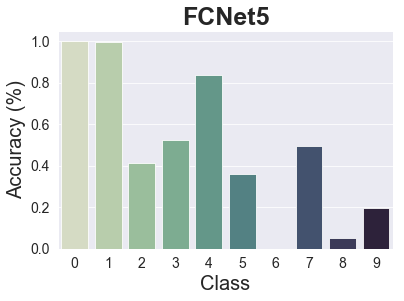

model_type: FCNet5 	 label: all 	 count: 10000 	 acc: 0.4957999885082245 

model_type: FCNet10 	 label: 0 	 count: 980 	 acc: 1.0
model_type: FCNet10 	 label: 1 	 count: 1135 	 acc: 0.0
model_type: FCNet10 	 label: 2 	 count: 1032 	 acc: 0.0
model_type: FCNet10 	 label: 3 	 count: 1010 	 acc: 0.0
model_type: FCNet10 	 label: 4 	 count: 982 	 acc: 0.0
model_type: FCNet10 	 label: 5 	 count: 892 	 acc: 0.0
model_type: FCNet10 	 label: 6 	 count: 958 	 acc: 0.0
model_type: FCNet10 	 label: 7 	 count: 1028 	 acc: 0.0
model_type: FCNet10 	 label: 8 	 count: 974 	 acc: 0.0
model_type: FCNet10 	 label: 9 	 count: 1009 	 acc: 0.0


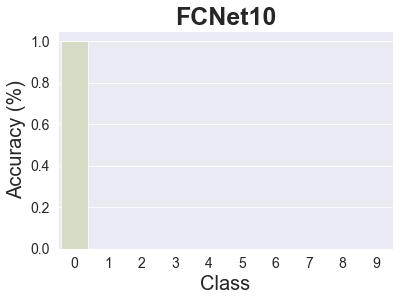

model_type: FCNet10 	 label: all 	 count: 10000 	 acc: 0.09799999743700027 

model_type: Conv1DNet 	 label: 0 	 count: 980 	 acc: 0.9969387650489807
model_type: Conv1DNet 	 label: 1 	 count: 1135 	 acc: 0.9991189241409302
model_type: Conv1DNet 	 label: 2 	 count: 1032 	 acc: 0.9844961166381836
model_type: Conv1DNet 	 label: 3 	 count: 1010 	 acc: 0.9772277474403381
model_type: Conv1DNet 	 label: 4 	 count: 982 	 acc: 0.9480651617050171
model_type: Conv1DNet 	 label: 5 	 count: 892 	 acc: 0.6636771559715271
model_type: Conv1DNet 	 label: 6 	 count: 958 	 acc: 0.907098114490509
model_type: Conv1DNet 	 label: 7 	 count: 1028 	 acc: 0.7247081995010376
model_type: Conv1DNet 	 label: 8 	 count: 974 	 acc: 0.6057494878768921
model_type: Conv1DNet 	 label: 9 	 count: 1009 	 acc: 0.6194251775741577


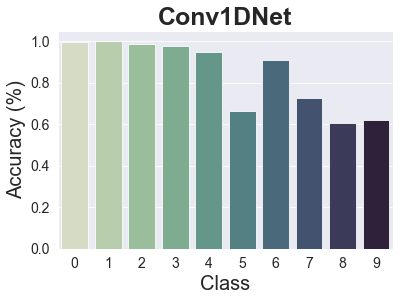

model_type: Conv1DNet 	 label: all 	 count: 10000 	 acc: 0.8465999960899353 

model_type: Conv2DNet 	 label: 0 	 count: 980 	 acc: 0.9989795684814453
model_type: Conv2DNet 	 label: 1 	 count: 1135 	 acc: 0.9982379078865051
model_type: Conv2DNet 	 label: 2 	 count: 1032 	 acc: 0.9728682041168213
model_type: Conv2DNet 	 label: 3 	 count: 1010 	 acc: 0.986138641834259
model_type: Conv2DNet 	 label: 4 	 count: 982 	 acc: 0.9837067127227783
model_type: Conv2DNet 	 label: 5 	 count: 892 	 acc: 0.8385650515556335
model_type: Conv2DNet 	 label: 6 	 count: 958 	 acc: 0.8622129559516907
model_type: Conv2DNet 	 label: 7 	 count: 1028 	 acc: 0.4649805426597595
model_type: Conv2DNet 	 label: 8 	 count: 974 	 acc: 0.72176593542099
model_type: Conv2DNet 	 label: 9 	 count: 1009 	 acc: 0.6481664776802063


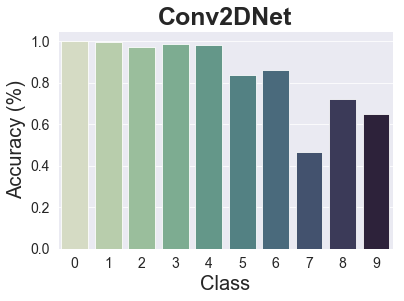

model_type: Conv2DNet 	 label: all 	 count: 10000 	 acc: 0.8486999869346619 



In [83]:
per_class_acc = np.zeros((10))
for X, y, desc in [(X_test_sr, y_test_sr, 'reverse stratified')]:
    print(desc)
    for model in [fcnet5, fcnet10, conv1dnet, conv2dnet]:
        model.cpu()
        model.eval()
        model_type = model.__class__.__name__
        for i in y_test_s.unique():
            idx = y == i
            X_ = X[idx]
            y_ = y[idx]
            acc = get_accuracy(model, X_, y_)
            per_class_acc[i] = acc
            print('model_type:', model_type, '\t', 
                  'label:', i.item(), '\t', 
                  'count:', len(y_), '\t',
                  'acc:', acc.item())
        sns.barplot(x=np.arange(len(per_class_acc)),y=per_class_acc)
        plt.xlabel('Class')
        plt.ylabel('Accuracy (%)')
        plt.title(label=model_type, weight='bold')
        plt.savefig('imgs/order_permutation/order_permutation_rs_e100_'+model_type+'.png')
        plt.show()
        acc = get_accuracy(model, X, y)
        print('model_type:', model_type, '\t', 
              'label:', 'all', '\t', 
              'count:', len(y), '\t',
              'acc:', acc.item(), '\n')